### Setup and Libraries

In [25]:
import warnings; warnings.simplefilter('ignore')
from statsmodels.graphics.tsaplots import plot_acf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

### Data Import

The dataset is loaded from a CSV file using `pandas.read_csv()`. The first column is parsed as the datetime index to align time series properly.

To simplify date handling, the datetime index is converted to plain date format (`YYYY-MM-DD`), removing time components. This ensures consistency when aligning and filtering time-based data throughout the analysis.


In [26]:
df_raw = pd.read_csv('data.csv', index_col=0, parse_dates=True)
df_raw.index = df_raw.index.date

### Defining the In-Sample and Out-of-Sample Split

We define a cutoff date of **May 1, 2024** to separate the in-sample period (used for model estimation) from the out-of-sample period (used for forecasting and evaluation).


In [27]:
cutoff = dt.date(2024, 5, 1)

In [28]:
df_insample = df_raw[df_raw.index < cutoff]

# EDA

### Cumulative Returns of Portfolio Components

The plot below shows the **cumulative returns** of each asset in the portfolio over the in-sample period. Each time series is normalized to 1 at the starting date, allowing for a direct comparison of relative performance across assets.

This visualization helps identify which instruments grew the most (or declined) during the period and provides insight into potential diversification benefits.


<Axes: title={'center': 'Cumulative Returns'}>

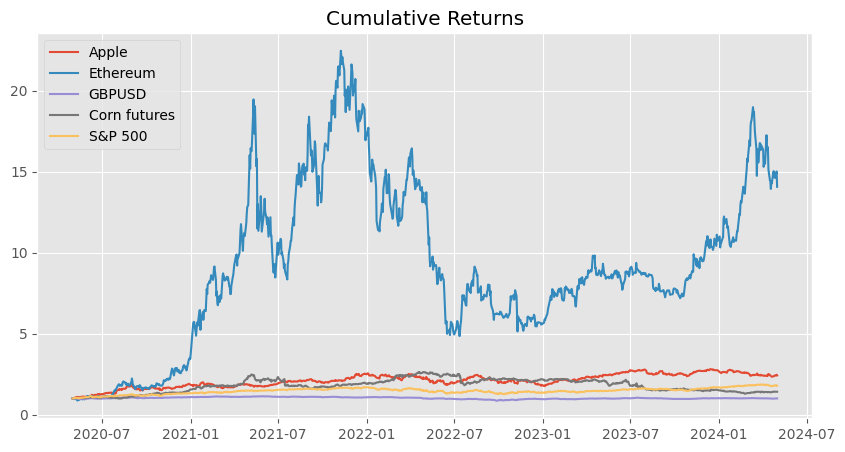

In [29]:
(df_insample / df_insample.iloc[0,:]).plot(title='Cumulative Returns', figsize=(10, 5), grid=True)

### Log Returns of Portfolio Components (In-Sample)

We compute the **daily logarithmic returns** for each asset in the portfolio during the in-sample period. This is done using the following formula:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

where:
- \( r_t \) is the log return at time \( t \),
- \( P_t \) is the price at time \( t \),
- \( P_{t-1} \) is the price at the previous time step.

Any resulting missing values (typically from the first row due to shifting) are dropped to ensure clean data for further analysis.


In [30]:
df_log_returns = np.log(df_insample / df_insample.shift(1))
df_log_returns = df_log_returns.dropna()

### Time Series of Log Returns for Individual Assets

The following subplots show the daily **log returns** of each asset in the portfolio during the in-sample period. 

Visual inspection of these time series allows us to:
- identify periods of increased or decreased volatility,
- observe potential **volatility clustering** (i.e., periods of high variability followed by more high variability),
- detect any visible anomalies or structural breaks in the return behavior.


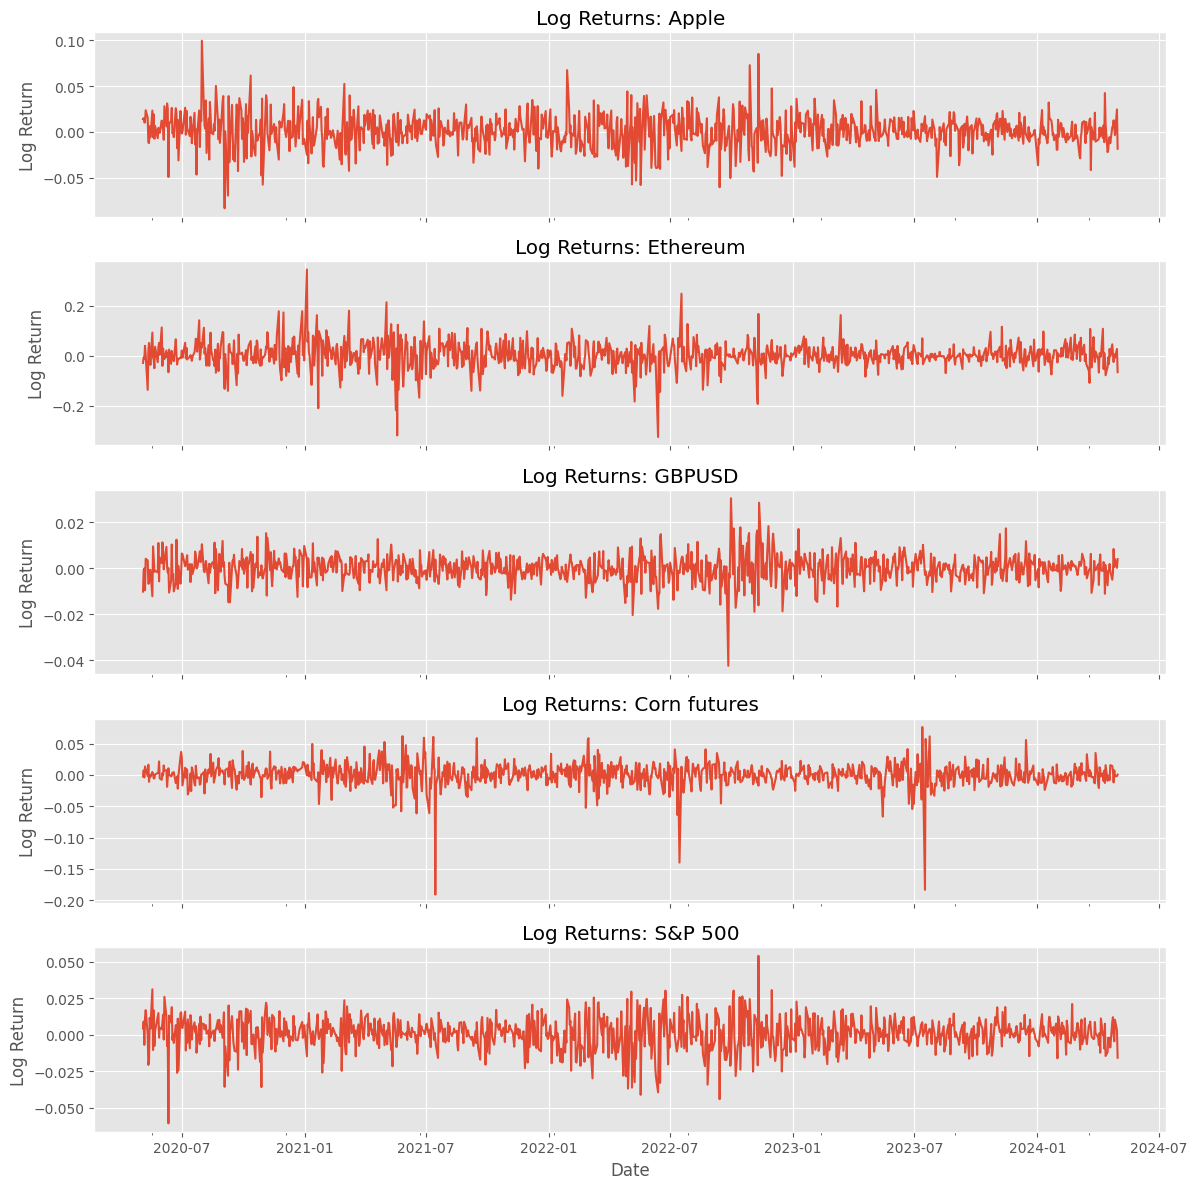

In [31]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12), sharex=True)

for i, asset in enumerate(df_log_returns.columns):
    ax = axes[i]
    df_log_returns[asset].plot(ax=ax)
    ax.set_title(f"Log Returns: {asset}")
    ax.set_ylabel("Log Return")
    ax.grid(True)
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

### Volatility Comparison Across Assets

The bar chart below presents the **standard deviation** of log returns (expressed in %) for each asset in the portfolio during the in-sample period.

This metric serves as a proxy for each asset's historical volatility. Assets with higher standard deviation exhibit more return variability, which typically corresponds to higher risk. This visualization provides a clear comparison of relative volatility across the portfolio components.


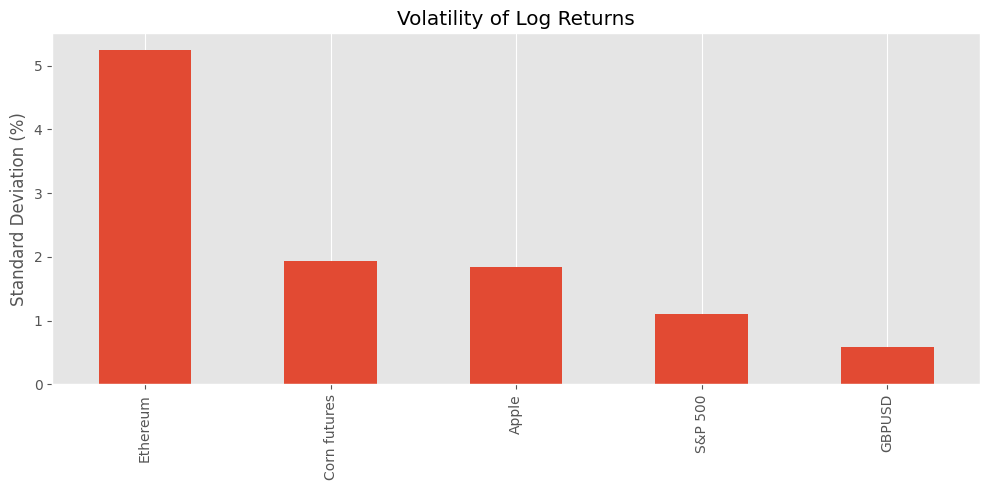

In [32]:
volatility = df_log_returns.std() * 100
volatility.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), 
                                             title='Volatility of Log Returns')
plt.ylabel("Standard Deviation (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Construction of Equally Weighted Portfolio and Log Returns

An **equally weighted portfolio** is constructed by allocating 20% of the initial investment to each of the five assets.

Steps:
- The initial portfolio value is set to 1.
- The number of shares for each asset is determined based on initial prices and equal weights.
- The portfolio value over time is calculated as the dot product of asset prices and the number of shares held.
- Finally, **portfolio log returns** are computed using the same lo


In [33]:
initial_value = 1
w = np.repeat(0.2, df_insample.shape[1])
allocation = initial_value * w
shares = allocation / df_insample.iloc[0]
portfolio = df_insample.dot(shares)

portfolio_insample = np.log(portfolio / portfolio.shift(1)).dropna()

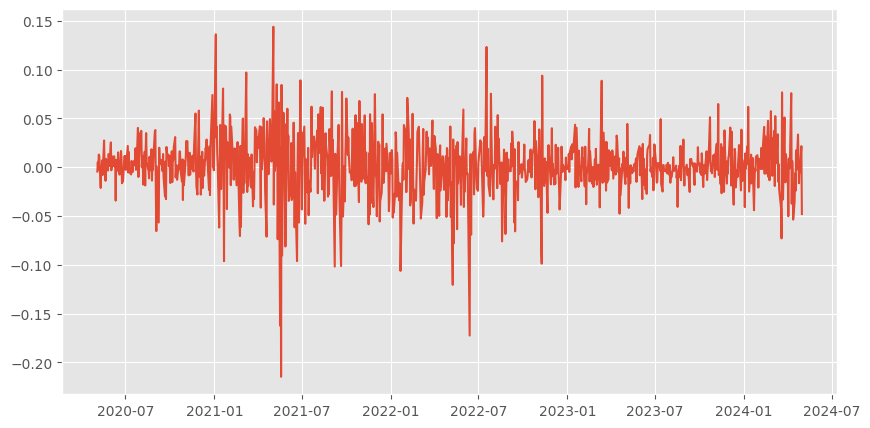

In [34]:
plt.plot(portfolio_insample)

### Distribution of Portfolio Log Returns and Kurtosis

The histogram below shows the distribution of the portfolio’s daily log returns, along with a **Kernel Density Estimate (KDE)** to provide a smooth approximation of the underlying probability density.

This allows us to assess the shape of the return distribution, particularly:
- its symmetry,
- presence of fat tails,
- deviation from normality.

To quantify this, we compute the **sample excess kurtosis** using Fisher’s definition. A positive excess kurtosis indicates **leptokurtosis** , a distribution with heavier tails and a sharper peak than the normal distribution.


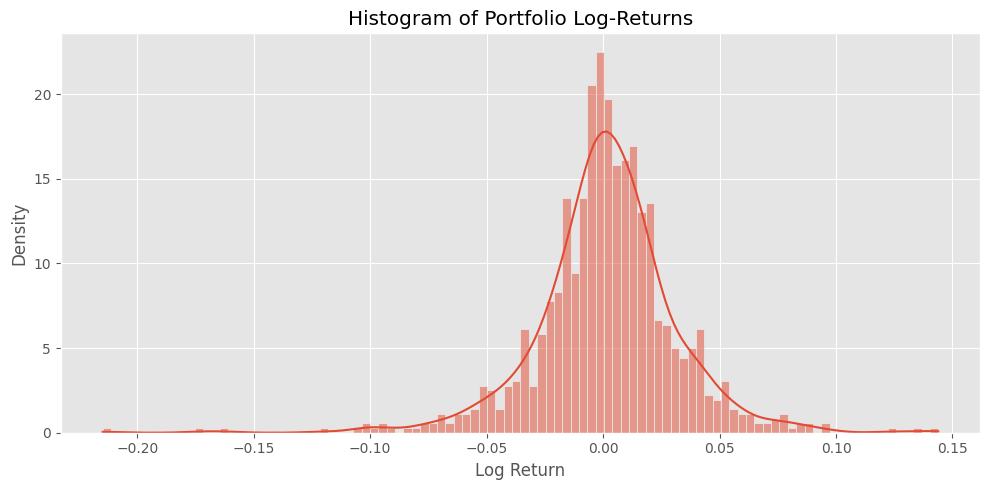

Sample excess kurtosis: 5.82


In [35]:
sns.histplot(portfolio_insample, bins=100, kde=True, stat='density')
plt.title('Histogram of Portfolio Log-Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

kurt = stats.kurtosis(portfolio_insample, fisher=True)
print(f"Sample excess kurtosis: {kurt:.2f}")

### Autocorrelation of Squared Portfolio Returns

To detect the presence of **ARCH effects** and **volatility clustering**, we analyze the **autocorrelation of squared portfolio log returns**.

The first plot shows the raw ACF of squared returns. The second plot applies a scaled y-axis for better visibility of lower lags. Significant autocorrelations in squared returns indicate that large fluctuations tend to be followed by large fluctuations — a key feature of financial time series that motivates the use of GARCH-type models.


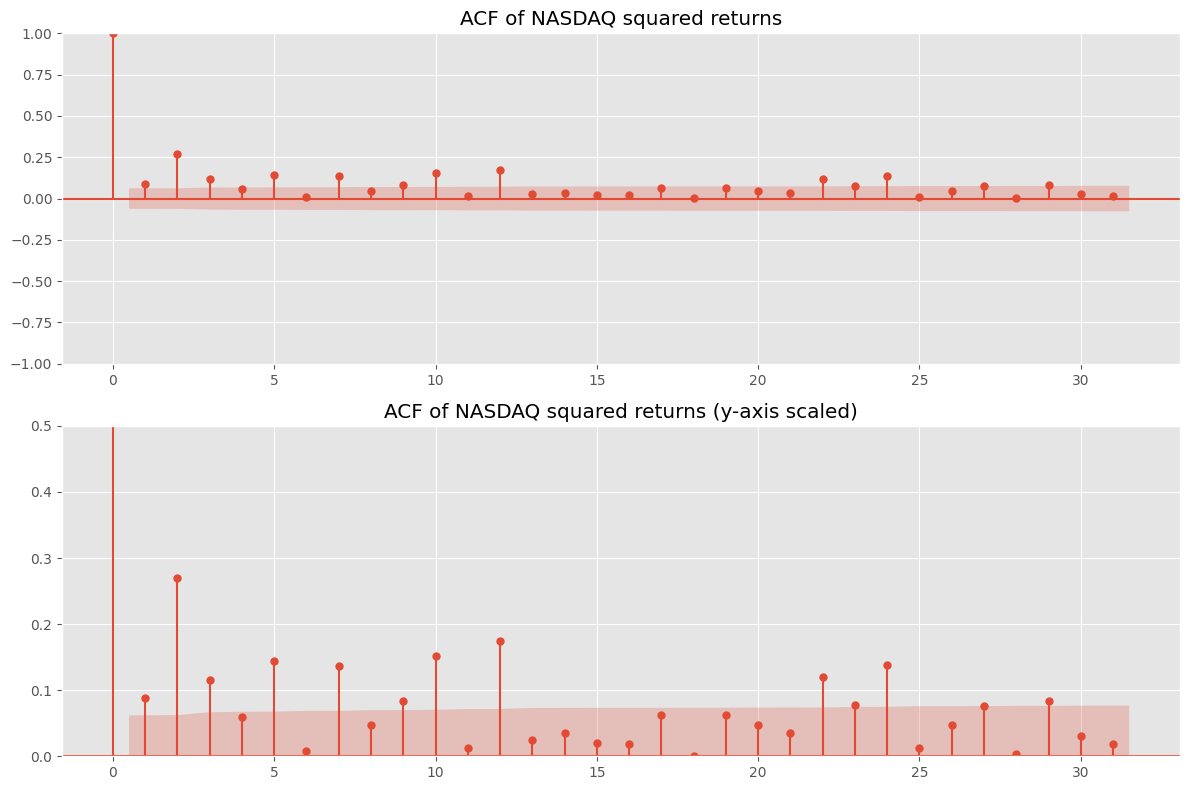

In [36]:
squared_returns_for_acf = (portfolio_insample ** 2).dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(squared_returns_for_acf, ax=axes[0], title="ACF of NASDAQ squared returns",)
plot_acf(squared_returns_for_acf, ax=axes[1], title="ACF of NASDAQ squared returns (y-axis scaled)", )
axes[1].set_ylim([0, 0.5])

plt.tight_layout()
plt.show()

autoregressive relationship, which allows to conclude that ARCH effects are present

Leverage effect

In [37]:
rets = portfolio_insample.copy()

window = 21
vol = rets.rolling(window).std() * np.sqrt(window)

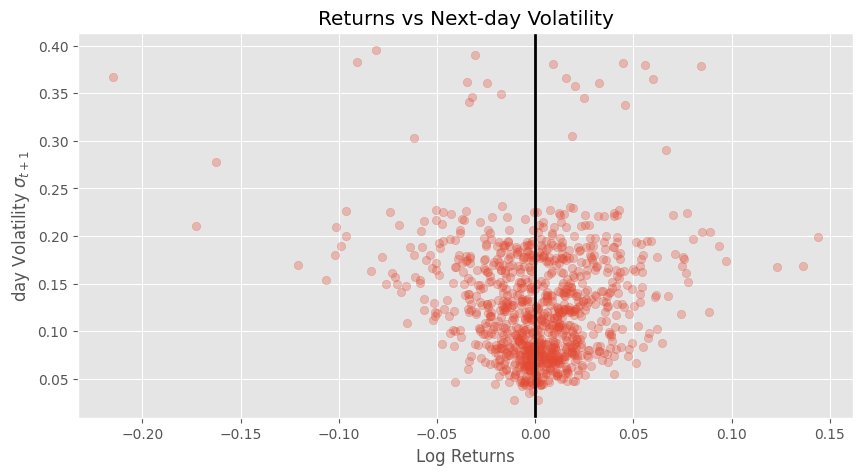

In [38]:
rets_lag = rets.iloc[:-1]
vol_next = vol.iloc[1:]

plt.scatter(rets_lag, vol_next, alpha=0.3)
plt.xlabel('Log Returns')
plt.ylabel(f'day Volatility $σ_{{t+1}}$')
plt.title('Returns vs Next-day Volatility')
plt.axvline(0, color='k', lw=2)
plt.show()


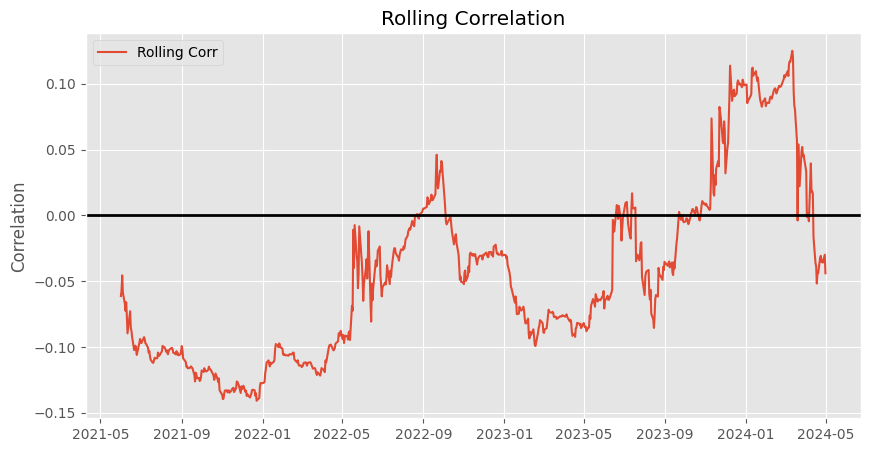

In [39]:
corr_window = 252
rolling_corr = rets.rolling(corr_window).corr(vol)

plt.plot(rolling_corr.index, rolling_corr, label=f'Rolling Corr')
plt.axhline(0, color='k', lw=2)
plt.title(f'Rolling Correlation')
plt.ylabel('Correlation')
plt.legend()
plt.show()

How much are the returns normal/fat-tailed?

In [40]:
def mad_calc(ts, rolling_window):
    rolling_mean = ts.rolling(rolling_window).mean()
    absolute_deviations = (ts - rolling_mean).abs()
    mads = absolute_deviations.rolling(rolling_window).mean()    
    return mads * np.sqrt(252)

def standard_dev_rolling(ts, rolling_window):
    ts = ts.copy()
    trading_periods = 252/rolling_window
    roll_std = ts.rolling(rolling_window).std()

    return roll_std * np.sqrt(252)

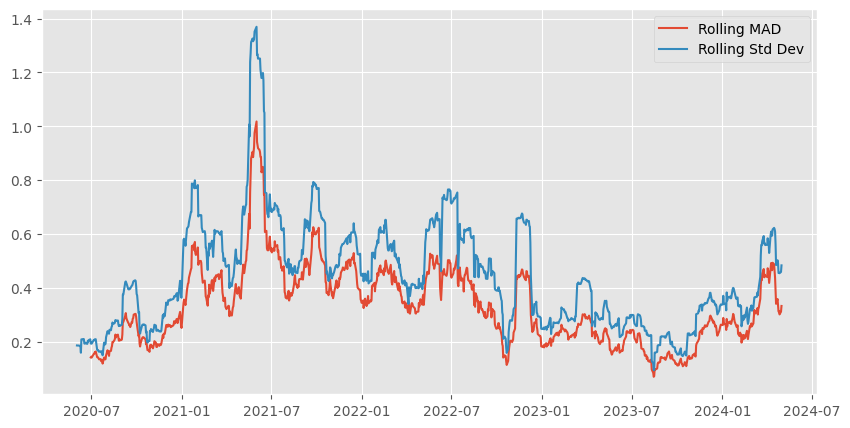

In [41]:
rolling_std = standard_dev_rolling(rets, 21)
rolling_MAD = mad_calc(rets, 21)
rolling_MAD.plot(label='Rolling MAD')
rolling_std.plot(label='Rolling Std Dev')
plt.legend()

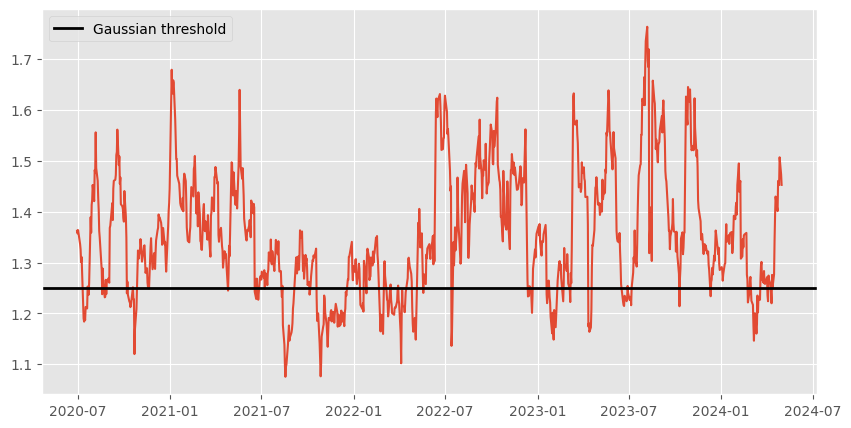

In [42]:
(rolling_std/rolling_MAD).plot()
plt.axhline(1.25, color='k', lw=2, label = "Gaussian threshold")
plt.legend()

In [43]:
def MSplot(data, p=4, save_path=None):
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(hspace=0.4)
    x = np.abs(data)
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    for i in range(1, p+1):
        y = np.power(x, i)
        S = np.cumsum(y)
        M = np.maximum.accumulate(y)
        R = M / S
        ax = axes[(i-1)//2, (i-1)%2]
        ax.plot(np.arange(1, len(x)+1), R)
        ax.set_xlabel('n')
        ax.set_ylabel('Rn')
        ax.set_title(f'MSplot for p={i}')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

<Figure size 1000x800 with 0 Axes>

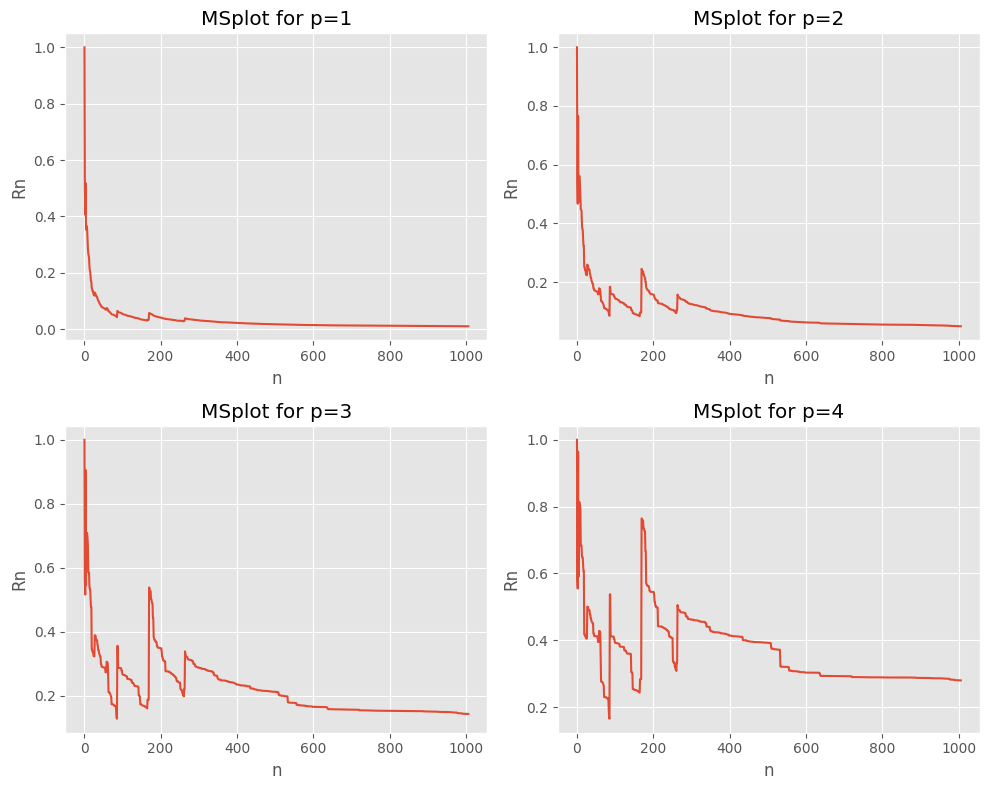

In [44]:
MSplot(portfolio_insample)

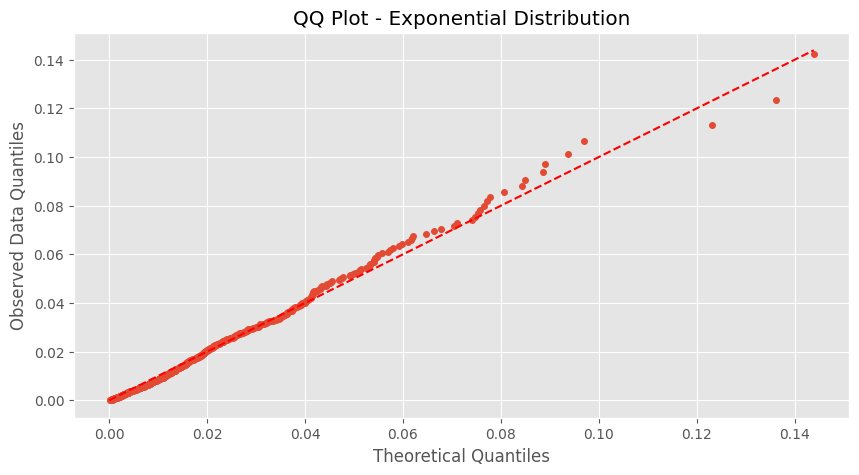

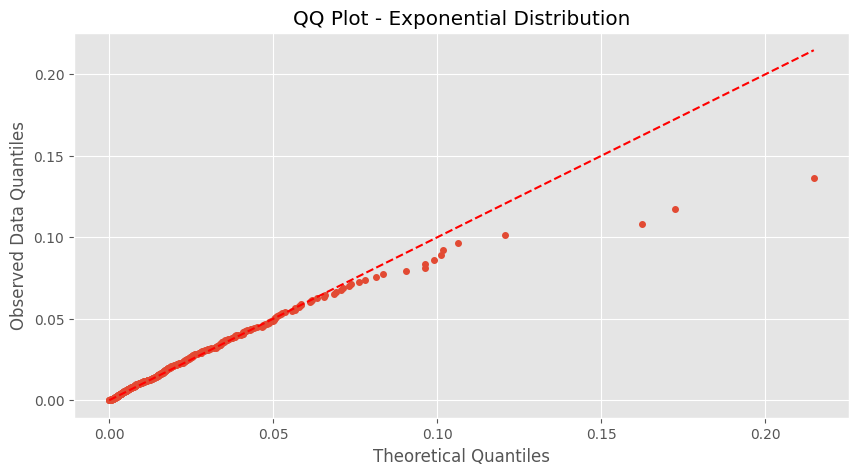

In [45]:
from scipy.stats import expon, probplot

def qqplot(data, save_path=None):
    # Calculate the intensity (rate parameter) for the exponential distribution
    data = np.sort(data.astype(float))
    intensity = 1 / np.mean(data)

    # Generate theoretical quantiles based on the fitted exponential distribution
    theoretical_quantiles = expon.ppf(np.linspace(0.01, 0.99, 100), scale=1 / intensity)

    ordered_data_quantiles, theoretical_quantiles = probplot(data, dist=expon(scale=1 / intensity), fit=False)
    plt.plot(theoretical_quantiles, ordered_data_quantiles, 'o', markersize=4)

    # Add diagonal line
    max_value = max(np.max(theoretical_quantiles), np.max(ordered_data_quantiles))
    min_value = min(np.min(theoretical_quantiles), np.min(ordered_data_quantiles))
    plt.plot([min_value, max_value], [min_value, max_value], 'r--', label='Diagonal')

    # Set plot labels and title
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Observed Data Quantiles')
    plt.title('QQ Plot - Exponential Distribution')
    plt.show()

qqplot(portfolio_insample[portfolio_insample>0])
qqplot(portfolio_insample[portfolio_insample<0].abs())

As you can see relying on sqaured variance (kurtosis) is not the best idea in general, but let's see

_____ 

# Models

### In-Sample

In [46]:
from arch import arch_model

In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

specs = [(p,q) for p in range(1,4) for q in range(1,4)]
results = []

for p, q in specs:
    model = arch_model(portfolio_insample, mean='constant', vol='GARCH', p=p, q=q)
    res   = model.fit(disp='off')
    
    std_resid = res.std_resid.dropna()
    
    lb_resid    = acorr_ljungbox(std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    lb_resid2   = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    
    arch_lm     = het_arch(std_resid, nlags=10)[1]
    
    results.append({
        'p': p, 'q': q,
        'AIC': res.aic,
        'LB_resid_p': lb_resid,
        'LB_resid2_p': lb_resid2,
        'ARCH_LM_p': arch_lm
    })

df_results = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
print(df_results)

   p  q          AIC  LB_resid_p  LB_resid2_p  ARCH_LM_p
0  1  1 -4387.461179    0.328956     0.292844   0.249504
1  2  1 -4386.052671    0.339349     0.356020   0.316330
2  1  2 -4385.461159    0.328977     0.292967   0.249609
3  3  1 -4384.052674    0.339336     0.355965   0.316275
4  2  2 -4383.332407    0.324380     0.298351   0.261189
5  2  3 -4382.688601    0.289875     0.205511   0.168336
6  3  2 -4378.813571    0.358840     0.383832   0.361835
7  1  3 -4375.935687    0.292924     0.070277   0.063230
8  3  3 -4373.982309    0.300871     0.120408   0.097358


In [48]:
best_specs = df_results[
    (df_results[['LB_resid_p','LB_resid2_p','ARCH_LM_p']] > 0.05).all(axis=1)
].head(2)

print("Selected specs:\n", best_specs[['p','q','AIC']])

Selected specs:
    p  q          AIC
0  1  1 -4387.461179
1  2  1 -4386.052671


In [49]:
best_specs

,p,q,AIC,LB_resid_p,LB_resid2_p,ARCH_LM_p
0,1,1,-4387.461179,0.328956,0.292844,0.249504
1,2,1,-4386.052671,0.339349,0.356020,0.316330


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2198.03
Distribution:                  Normal   AIC:                          -4386.05
Method:            Maximum Likelihood   BIC:                          -4361.49
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        15:27:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7051e-03  7.456e-04      2.287  2.220e-02 [2.

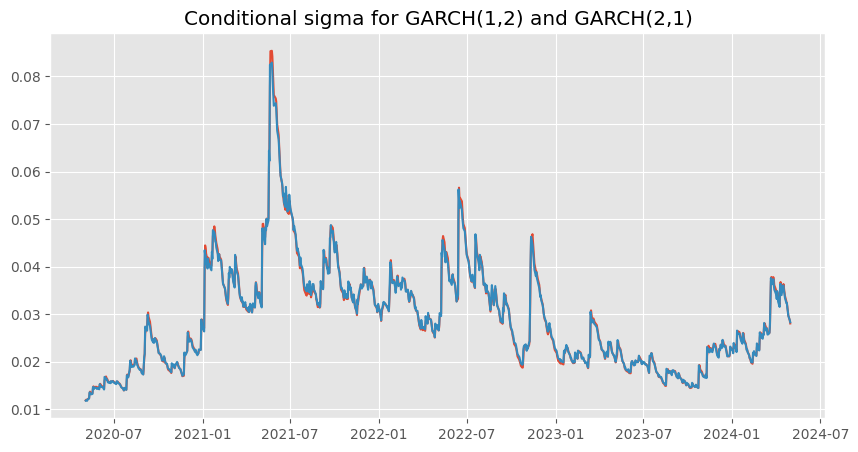

<Figure size 1000x500 with 0 Axes>

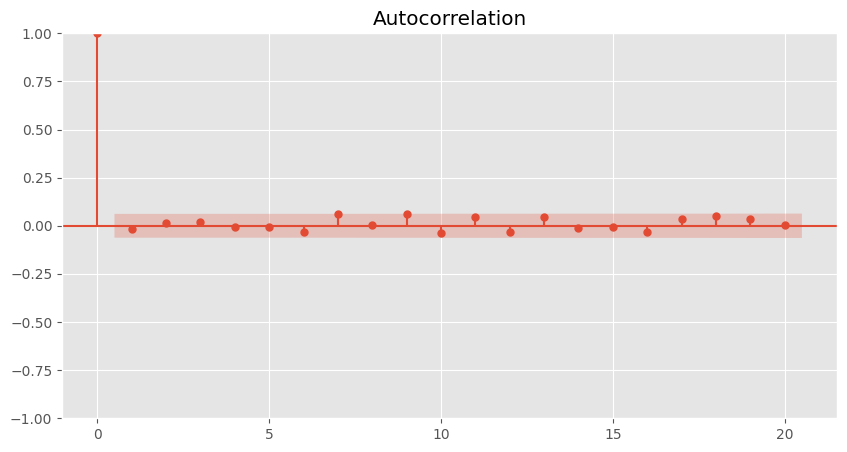

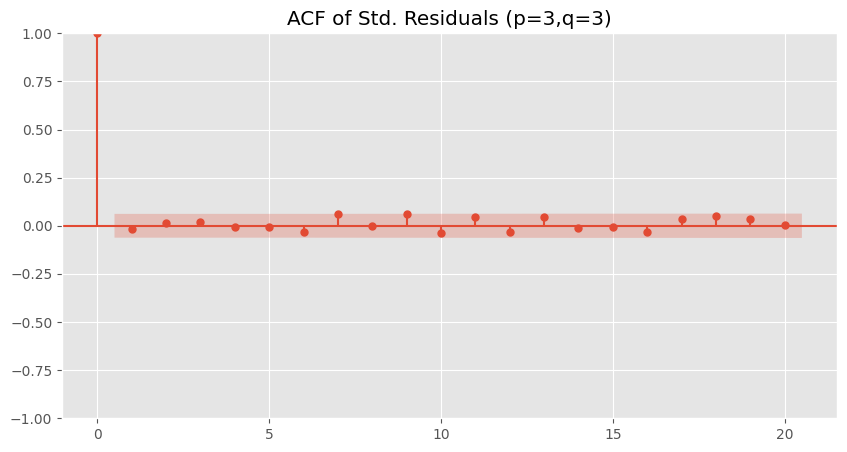

<Figure size 1000x500 with 0 Axes>

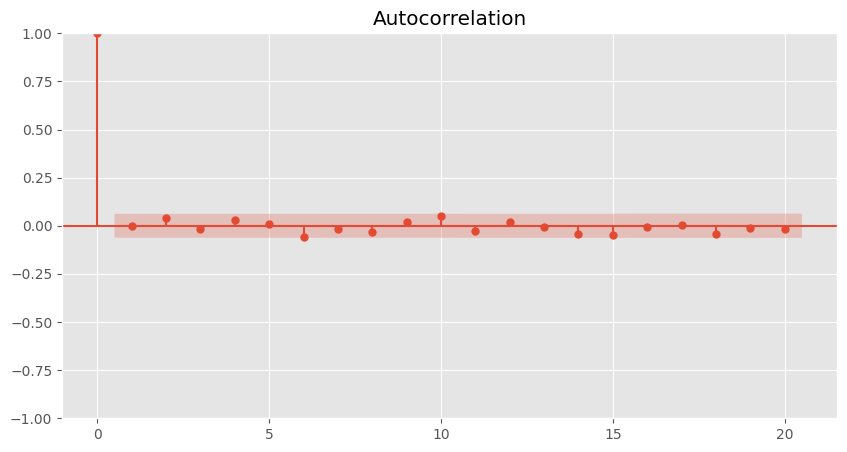

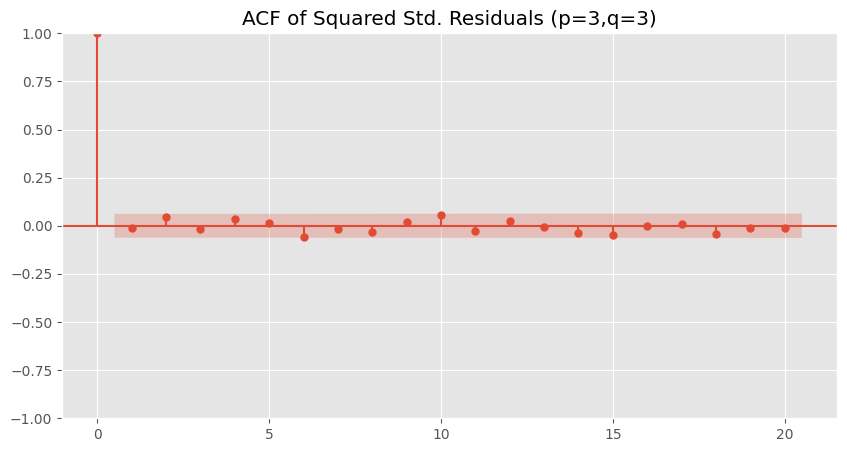

In [50]:
res21  = arch_model(portfolio_insample, mean='constant', vol='GARCH', p=2, q=1).fit(disp='off')
res12  = arch_model(portfolio_insample, mean='constant', vol='GARCH', p=1, q=2).fit(disp='off')
    
print(res21.summary())
print(res12.summary())
    
plt.figure()
plt.plot(res21.conditional_volatility)
plt.plot(res12.conditional_volatility)
plt.title(f'Conditional sigma for GARCH(1,2) and GARCH(2,1)')
plt.show()
    
plt.figure()
plot_acf(res21.std_resid.dropna(), lags=20)
plot_acf(res12.std_resid.dropna(), lags=20)
plt.title(f'ACF of Std. Residuals (p={p},q={q})')
plt.show()
    
plt.figure()
plot_acf(res21.std_resid.dropna()**2, lags=20)
plot_acf(res12.std_resid.dropna()**2, lags=20)
plt.title(f'ACF of Squared Std. Residuals (p={p},q={q})')
plt.show()


In [51]:
model_garch12 = arch_model(portfolio_insample.dropna(), mean='constant', vol='GARCH', p=2,  q=1)
results_garch12 = model_garch12.fit(disp='off')

In [52]:
model_egarch12 = arch_model(portfolio_insample.dropna(), mean='constant', vol='EGARCH', p=1,  q=2)
results_egarch12 = model_egarch12.fit(disp='off')
print("EDGARCH(1,2) Model Results:")
print(results_egarch12.summary())

EDGARCH(1,2) Model Results:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                2204.40
Distribution:                  Normal   AIC:                          -4398.80
Method:            Maximum Likelihood   BIC:                          -4374.23
                                        No. Observations:                 1005
Date:                Fri, May 30 2025   Df Residuals:                     1004
Time:                        15:27:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7534e-03  7.114e-

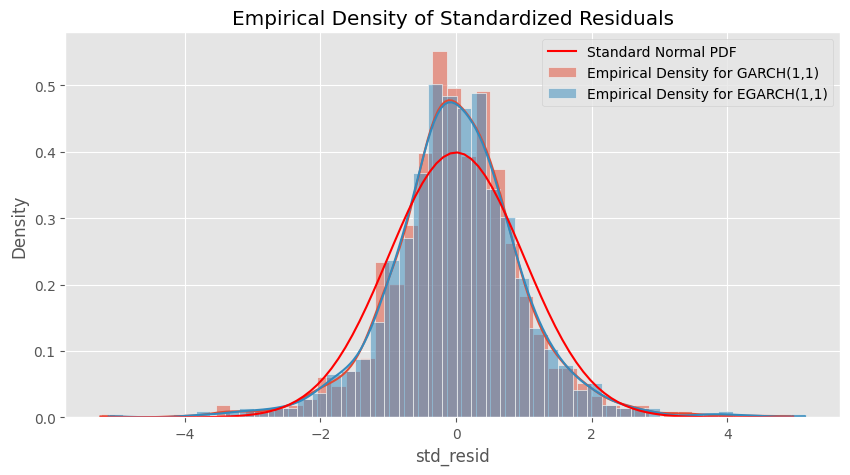

In [53]:
std_resid_egarch = results_egarch12.std_resid.dropna()
std_resid_garch = results_garch12.std_resid.dropna()

sns.histplot(std_resid_garch, kde=True, stat="density", label='Empirical Density for GARCH(1,1)')
sns.histplot(std_resid_egarch, kde=True, stat="density", label='Empirical Density for EGARCH(1,1)')
# Overlay standard normal for comparison
x_norm = np.linspace(std_resid_garch.min(), std_resid_garch.max(), 100)
plt.plot(x_norm, stats.norm.pdf(x_norm, 0, 1), label='Standard Normal PDF', color='red')
plt.title('Empirical Density of Standardized Residuals')
plt.legend()

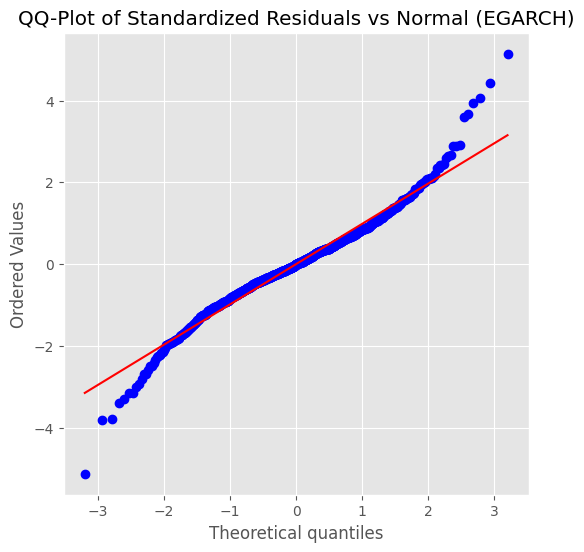

In [54]:
plt.figure(figsize=(6, 6))
stats.probplot(std_resid_egarch, dist="norm", plot=plt)
plt.title('QQ-Plot of Standardized Residuals vs Normal (EGARCH)')
plt.show()

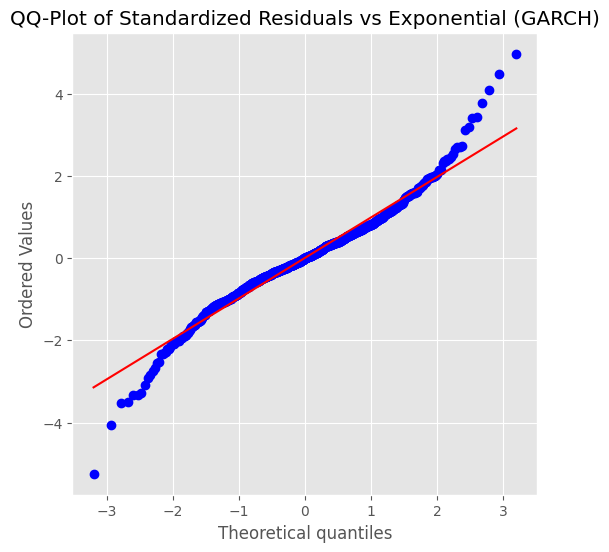

In [55]:
plt.figure(figsize=(6, 6))
stats.probplot(std_resid_garch, dist="norm", plot=plt)
plt.title('QQ-Plot of Standardized Residuals vs Exponential (GARCH)')
plt.show()

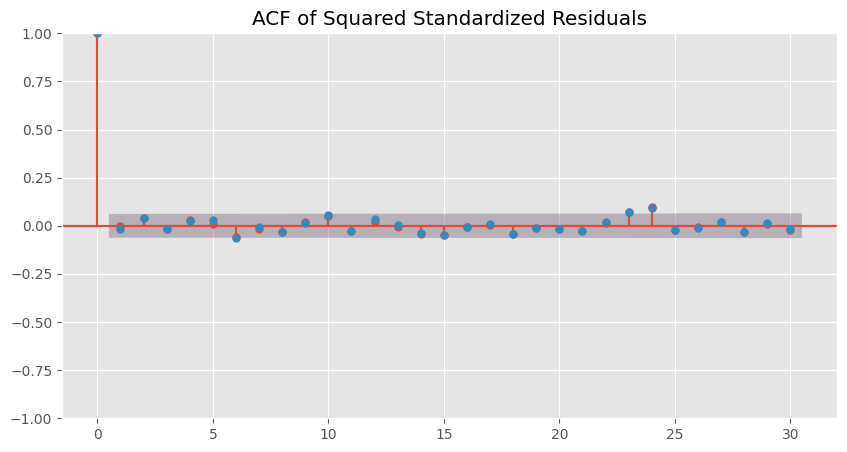

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(std_resid_garch**2, ax=ax, lags=30, title='ACF of Squared Standardized Residuals')
plot_acf(std_resid_egarch**2, ax=ax, lags=30, title='ACF of Squared Standardized Residuals')
plt.show()

In [57]:
params_egarch = results_egarch12.params
params_garch = results_garch12.params

df_params = pd.DataFrame({
    'EGARCH(1,1)': params_egarch,
    'GARCH(1,1)': params_garch
})

metrics = pd.DataFrame({
    'Model': ['EGARCH(1,1)', 'GARCH(1,1)'],
    'LogLikelihood': [results_egarch12.loglikelihood, results_garch12.loglikelihood],
    'AIC': [results_egarch12.aic, results_garch12.aic],
    'BIC': [results_egarch12.bic, results_garch12.bic]
})

metrics

,Model,LogLikelihood,AIC,BIC
0,"EGARCH(1,1)",2204.399184,-4398.798368,-4374.234654
1,"GARCH(1,1)",2198.026336,-4386.052671,-4361.488957


GARCH does not seem to be a good model, but let's go with it

Anyway, because EGARCH delivers a higher (less negative) log-likelihood and lower AIC/BIC, it’s the preferred specification here.

### Out-of-Sample

In [58]:
out_of_sample = df_raw[df_raw.index >= cutoff]

initial_value = 1_000_000
w = np.repeat(0.2, out_of_sample.shape[1])
allocation = initial_value * w
shares = allocation / out_of_sample.iloc[0] 
portfolio_value = out_of_sample.dot(shares)

out_of_sample_ret = np.log(portfolio_value / portfolio_value.shift(1))
portfolio_out_of_sample = out_of_sample_ret.dropna()

In [59]:
model     = arch_model(portfolio_insample.dropna(),
                       mean='Constant', vol='GARCH', p=1, q=2)
res       = model.fit(disp='off', show_warning=False)
fcast_ins = res.forecast(horizon=1, reindex=False)
sigma_ins = np.sqrt(fcast_ins.variance.iloc[-1, 0])

In [60]:
vol_pred = pd.Series(index=portfolio_out_of_sample.index, dtype=float)
var      = pd.Series(index=portfolio_out_of_sample.index, dtype=float)
q01_model = stats.norm.ppf(0.01)

counter = 0
for dt in portfolio_out_of_sample.index:
    hist = portfolio_out_of_sample.loc[:dt].dropna()
    res = arch_model(hist, mean='Constant', vol='GARCH', p=1, q=2)\
              .fit(disp='off', show_warning=False)
    sigma = np.sqrt(res.forecast(horizon=1, reindex=False)
                   .variance.iloc[-1, 0])
    if counter == 0:
        sigma = sigma_ins
    
    vol_pred.loc[dt] = sigma
    var.loc[dt] = q01_model * sigma
    counter += 1

res_df = pd.DataFrame({
    'Ret': portfolio_out_of_sample,
    'Vol': vol_pred,
    'VaR': var
})

In [61]:
VaR_breached = res_df[res_df['Ret'].abs() > res_df['VaR'].abs()]

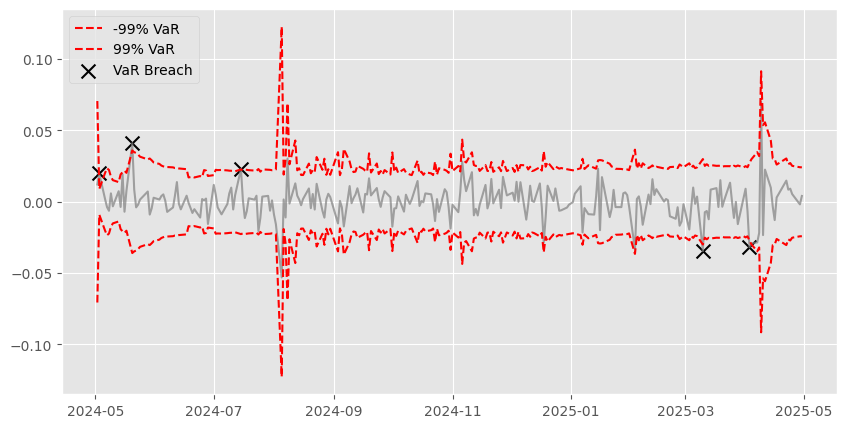

In [62]:
plt.plot(res_df['Ret'], color='grey', alpha=0.7)
plt.plot(-res_df['VaR'], label=f'-{int((1-0.01)*100)}% VaR', color='red', linestyle='--')
plt.plot(res_df['VaR'], label=f'{int((1-0.01)*100)}% VaR', color='red', linestyle='--')
plt.scatter(VaR_breached.index, VaR_breached.Ret, color='black', label='VaR Breach', marker='x',s = 100)
plt.legend()
plt.show()

In [63]:
from statsmodels.stats.proportion import proportions_ztest

In [64]:
exceptions = (res_df['Ret'] < -res_df['VaR']).astype(int)
n_exceptions = exceptions.sum()
n_tests = exceptions.count()
empirical_rate = n_exceptions / n_tests
theoretical_rate = 0.01

stat, p_value = proportions_ztest(n_exceptions, n_tests, theoretical_rate, alternative='larger')

print(f"Number of observations: {n_tests}")
print(f"Number of exceptions:  {n_exceptions}")
print(f"Empirical exception rate: {empirical_rate:.4f}")
print(f"Theoretical rate:    {theoretical_rate:.4f}")
print(f"Kupiec POF test p-value:  {p_value:.4f}")

Number of observations: 248
Number of exceptions:  245
Empirical exception rate: 0.9879
Theoretical rate:    0.0100
Kupiec POF test p-value:  0.0000


VaR is bad. p-value < 0.05 means that the null hypothesis that VaR model is adequate shoudl be rejcted

In [65]:
from scipy.stats import chi2

def christoffersen_independence_test(violations):

    Vi = violations
    N00 = np.sum((Vi[:-1] == 0) & (Vi[1:] == 0))
    N01 = np.sum((Vi[:-1] == 0) & (Vi[1:] == 1))
    N10 = np.sum((Vi[:-1] == 1) & (Vi[1:] == 0))
    N11 = np.sum((Vi[:-1] == 1) & (Vi[1:] == 1))

    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0

    L0 = ((1 - (N01+N11)/(N00+N01+N10+N11))**(N00+N10) *
          ((N01+N11)/(N00+N01+N10+N11))**(N01+N11))
    L1 = ((1 - pi0)**N00 * pi0**N01 * (1 - pi1)**N10 * pi1**N11)

    LR_ind = -2 * (np.log(L0) - np.log(L1))
    p_value = 1 - chi2.cdf(LR_ind, df=1)
    return LR_ind, p_value


def christoffersen_conditional_coverage_test(violations, alpha):
    n = len(violations)
    x = np.sum(violations)
    L_uc = (alpha**x) * ((1 - alpha)**(n - x))
    L_bin = ((x/n)**x) * ((1 - x/n)**(n - x))
    LR_uc = -2 * (np.log(L_uc) - np.log(L_bin))

    LR_ind, _ = christoffersen_independence_test(violations)

    LR_cc = LR_uc + LR_ind
    p_value = 1 - chi2.cdf(LR_cc, df=2)
    return LR_cc, p_value

In [66]:
exceptions = (res_df['Ret'] < res_df['VaR']).astype(int).values
n_exceptions = exceptions.sum()
n_tests = len(exceptions)
emp_rate = n_exceptions / n_tests

theoretical_rate = 0.01
kp_stat, kp_p = proportions_ztest(
    count=n_exceptions,
    nobs=n_tests,
    value=theoretical_rate,
    alternative='larger'
)

ci_stat, ci_p = christoffersen_independence_test(exceptions)
ccc_stat, ccc_p = christoffersen_conditional_coverage_test(exceptions, theoretical_rate)

print(f"Total Observations: {n_tests}")
print(f"Exceptions: {n_exceptions} (Empirical Rate: {emp_rate:.4f})")
print(f"Kupiec POF Test: Stat={kp_stat:.4f}, p-value={kp_p:.4f}\n")
print(f"Christoffersen Independence Test: Stat={ci_stat:.4f}, p-value={ci_p:.4f}")
print(f"Christoffersen Conditional Coverage Test: Stat={ccc_stat:.4f}, p-value={ccc_p:.4f}")

Total Observations: 248
Exceptions: 2 (Empirical Rate: 0.0081)
Kupiec POF Test: Stat=-0.3408, p-value=0.6334

Christoffersen Independence Test: Stat=0.0327, p-value=0.8566
Christoffersen Conditional Coverage Test: Stat=0.1331, p-value=0.9356
